# Imports

In [94]:
import json, random

In [95]:
from market import Market, Produto

In [96]:
from PIL import Image
from IPython.display import display

# Static Values

In [97]:
CART: dict = {
    'Altura': 65,
    'Largura': 50,
    'Comprimento': 80,
    'PesoMaximo': 460*1000
}

CART['Capacidade'] = CART['Altura'] * CART['Largura'] * CART['Comprimento']

CART

{'Altura': 65,
 'Largura': 50,
 'Comprimento': 80,
 'PesoMaximo': 460000,
 'Capacidade': 260000}

In [98]:
MAX_MONEY: float = 2000.0
MAX_ITEMS: int = 10
MAX_CARTS: int = MAX_ITEMS*10
MAX_GENERATIONS: int = 1000
BESTS: int = 15

# Funções

In [99]:
m: Market = Market(r"C:\Users\Arklok\Documents\Projetos\gen-algorithm\data\produtos.csv")

In [100]:
def mosaic(cart: list[Produto], row_quantity: int = 5, image_size: tuple[int, int] = (300, 300)) -> None:
    images: list[Image] = [product.show(popup=False).resize(image_size) for product in cart]
    
    mosaic_size: tuple[int, int] = (image_size[0]*row_quantity, image_size[1]*((len(images)//row_quantity)+1))
    
    mosaic: Image = Image.new('RGB', mosaic_size)
    
    for i, image in enumerate(images):
        mosaic.paste(image, (image_size[0]*(i%row_quantity), image_size[1]*(i//row_quantity)))
    
    display(mosaic) 

# Genético

### Geração de Indivíduos

In [101]:
def gerar_carrinho(tamanho: int = globals()['MAX_ITEMS']) -> list[Produto]:
    compra = []

    while len(compra) < tamanho:
        item: Produto = m.random()
        compra.append(item)
        
    return compra

In [102]:
c: list[Produto] = gerar_carrinho()
c

[<Produto(id=1446530>,
 <Produto(id=1493472>,
 <Produto(id=1624531>,
 <Produto(id=431866>,
 <Produto(id=431868>,
 <Produto(id=409753>,
 <Produto(id=152694>,
 <Produto(id=457547>,
 <Produto(id=278608>,
 <Produto(id=236602>]

### Geração de População Inicial

In [103]:
def gerar_populacao(tamanho: int = globals()['MAX_CARTS']) -> list[list[Produto]]:
    return [gerar_carrinho() for _ in range(tamanho)]

In [104]:
p: list[list[Produto]] = gerar_populacao()
p

[[<Produto(id=25181>,
  <Produto(id=425600>,
  <Produto(id=419001>,
  <Produto(id=584622>,
  <Produto(id=1433064>,
  <Produto(id=411019>,
  <Produto(id=101493>,
  <Produto(id=419003>,
  <Produto(id=697134>,
  <Produto(id=62145>],
 [<Produto(id=113253>,
  <Produto(id=584617>,
  <Produto(id=42166>,
  <Produto(id=464005>,
  <Produto(id=74109>,
  <Produto(id=170800>,
  <Produto(id=181458>,
  <Produto(id=324197>,
  <Produto(id=318904>,
  <Produto(id=181474>],
 [<Produto(id=697134>,
  <Produto(id=1568669>,
  <Produto(id=1461013>,
  <Produto(id=97185>,
  <Produto(id=1618540>,
  <Produto(id=583963>,
  <Produto(id=383831>,
  <Produto(id=1446530>,
  <Produto(id=190826>,
  <Produto(id=153540>],
 [<Produto(id=1606865>,
  <Produto(id=152694>,
  <Produto(id=181474>,
  <Produto(id=461591>,
  <Produto(id=44486>,
  <Produto(id=169950>,
  <Produto(id=165385>,
  <Produto(id=379876>,
  <Produto(id=150385>,
  <Produto(id=1622212>],
 [<Produto(id=184788>,
  <Produto(id=343565>,
  <Produto(id=36020>,
  <Prod

### Avaliação

In [105]:
# def avaliar(individuo: list[Produto], valor_limite: float = globals()['MAX_MONEY']) -> float:
#     valor_compra: float = 0.0
    
#     for item in individuo:
#         valor_compra += item.price

#     if valor_compra > valor_limite:
#         return float('inf')
    
#     else:
#         return valor_compra

In [106]:
def avaliar(individuo: list[Produto], 
            valor_limite: float = globals()['MAX_MONEY'], 
            max_peso: float = CART['PesoMaximo'], 
            max_volume: float = CART['Capacidade'],
            max_itens: int = globals()['MAX_ITEMS']
            ) -> float:

    valor_compra: float = 0.0
    peso_total: float = 0.0
    volume_total: float = 0.0
    categorias: set = set()
    repeticoes: int = 0

    for item in individuo:
        valor_compra += item.price
        peso_total += item.weight
        volume_item = item.height * item.width * item.depth
        volume_total += volume_item
        
        categorias.add(item.category)
        
        # Contar repetições de produtos
        if individuo.count(item) > 1:
            repeticoes += 1

    # Penalidades
    nota = 0.0

    # Penalidade por exceder o limite de dinheiro
    if valor_compra > valor_limite:
        nota += (valor_compra - valor_limite) * 10  # Ajuste de penalidade
    
    # Penalidade por excesso de peso
    if peso_total > max_peso:
        nota += (peso_total - max_peso) * 15  # Ajuste de penalidade

    # Penalidade por excesso de volume
    if volume_total > max_volume:
        nota += (volume_total - max_volume) * 20  # Ajuste de penalidade

    # Penalidade por número excessivo de itens
    if len(individuo) > max_itens:
        nota += (len(individuo) - max_itens) * 5  # Ajuste de penalidade

    # Penalidade por repetição de produtos
    nota += repeticoes * 10  # Penalidade por cada produto repetido

    # Incentivo pela diversidade de categorias
    nota -= len(categorias) * 5  # Deduz nota pela diversidade de categorias

    # Final result is the total cost plus penalizations
    return valor_compra + nota


In [107]:
n: float = avaliar(c)
n

162.87

In [108]:
def mapear_notas(populacao: list[list[Produto]], order: str = 'asc') -> dict[float, list[Produto]]:
    notas: dict = {avaliar(individuo): individuo for individuo in populacao}
    
    if order == 'asc':
        return dict(sorted(notas.items()))
    
    else:
        return dict(sorted(notas.items(), reverse=True))

In [109]:
nt: dict[float, list[Produto]] = mapear_notas(p)
nt

{62.2: [<Produto(id=1616567>,
  <Produto(id=74949>,
  <Produto(id=1591037>,
  <Produto(id=1615262>,
  <Produto(id=472091>,
  <Produto(id=479199>,
  <Produto(id=457548>,
  <Produto(id=66453>,
  <Produto(id=174284>,
  <Produto(id=1606864>],
 99.20999999999998: [<Produto(id=82880>,
  <Produto(id=1441479>,
  <Produto(id=409359>,
  <Produto(id=1376293>,
  <Produto(id=439797>,
  <Produto(id=50670>,
  <Produto(id=1616281>,
  <Produto(id=12628>,
  <Produto(id=145673>,
  <Produto(id=173710>],
 106.56: [<Produto(id=278608>,
  <Produto(id=465051>,
  <Produto(id=318906>,
  <Produto(id=113943>,
  <Produto(id=97199>,
  <Produto(id=182374>,
  <Produto(id=25181>,
  <Produto(id=467659>,
  <Produto(id=19468>,
  <Produto(id=9498>],
 107.16: [<Produto(id=221360>,
  <Produto(id=330820>,
  <Produto(id=168623>,
  <Produto(id=383831>,
  <Produto(id=796084>,
  <Produto(id=44486>,
  <Produto(id=421225>,
  <Produto(id=335996>,
  <Produto(id=467659>,
  <Produto(id=326862>],
 107.69: [<Produto(id=470249>,
  <Produ

### Seleção

In [110]:
def torneio(populacao: list[list[Produto]]) -> list[list[Produto]]:
    vencedores: list[list[Produto] | None] = []
    
    while len(vencedores) < 2:
        competidor_1: list[Produto] = random.choice(populacao)
        competidor_2: list[Produto] = random.choice(populacao)
                
        # Seleção do melhor individuo:
        if avaliar(competidor_1) < avaliar(competidor_2):
            vencedor: list[Produto] = competidor_1
        
        else:
            vencedor: list[Produto] = competidor_2
            
        if vencedor not in vencedores:
            vencedores.append(vencedor)
    
    return vencedores

In [111]:
v1: list[list[Produto]] = torneio(p)
v1

[[<Produto(id=1616567>,
  <Produto(id=328080>,
  <Produto(id=51141>,
  <Produto(id=332651>,
  <Produto(id=128337>,
  <Produto(id=11113>,
  <Produto(id=181474>,
  <Produto(id=51876>,
  <Produto(id=796083>,
  <Produto(id=302930>],
 [<Produto(id=419004>,
  <Produto(id=1614972>,
  <Produto(id=379881>,
  <Produto(id=145673>,
  <Produto(id=473749>,
  <Produto(id=328762>,
  <Produto(id=51141>,
  <Produto(id=1379112>,
  <Produto(id=454739>,
  <Produto(id=451163>]]

In [112]:
def roleta_viciada(populacao: list[list[Produto]]) -> list[list[Produto]]:
    fitness_list: list[float] = [1 / avaliar(individuo) for individuo in populacao]
    total_fitness: float = sum(fitness_list)
    probabilities: list[float] = [fitness / total_fitness for fitness in fitness_list]
    
    vencedores: list[list[Produto]] = random.choices(populacao, weights=probabilities, k=2)
    
    return vencedores

In [126]:
v2: list[list[Produto]] = roleta_viciada(p)
v2

[[<Produto(id=760243>,
  <Produto(id=1377630>,
  <Produto(id=1433064>,
  <Produto(id=1377277>,
  <Produto(id=282731>,
  <Produto(id=218078>,
  <Produto(id=71969>,
  <Produto(id=585390>,
  <Produto(id=321143>,
  <Produto(id=345967>],
 [<Produto(id=4700>,
  <Produto(id=13918>,
  <Produto(id=456448>,
  <Produto(id=1628300>,
  <Produto(id=42870>,
  <Produto(id=1618531>,
  <Produto(id=181478>,
  <Produto(id=65885>,
  <Produto(id=868>,
  <Produto(id=365395>]]

In [114]:
def eugenia(populacao: list[list[Produto]], order: str = 'asc') -> list[list[Produto]]:
    notas: dict[float, list[Produto]] = mapear_notas(populacao, order)
    melhores: list[list[Produto]] = list(notas.values())[:globals()['BESTS']]
    
    return melhores

In [115]:
e: list[list[Produto]] = eugenia(p)
e

[[<Produto(id=1616567>,
  <Produto(id=74949>,
  <Produto(id=1591037>,
  <Produto(id=1615262>,
  <Produto(id=472091>,
  <Produto(id=479199>,
  <Produto(id=457548>,
  <Produto(id=66453>,
  <Produto(id=174284>,
  <Produto(id=1606864>],
 [<Produto(id=82880>,
  <Produto(id=1441479>,
  <Produto(id=409359>,
  <Produto(id=1376293>,
  <Produto(id=439797>,
  <Produto(id=50670>,
  <Produto(id=1616281>,
  <Produto(id=12628>,
  <Produto(id=145673>,
  <Produto(id=173710>],
 [<Produto(id=278608>,
  <Produto(id=465051>,
  <Produto(id=318906>,
  <Produto(id=113943>,
  <Produto(id=97199>,
  <Produto(id=182374>,
  <Produto(id=25181>,
  <Produto(id=467659>,
  <Produto(id=19468>,
  <Produto(id=9498>],
 [<Produto(id=221360>,
  <Produto(id=330820>,
  <Produto(id=168623>,
  <Produto(id=383831>,
  <Produto(id=796084>,
  <Produto(id=44486>,
  <Produto(id=421225>,
  <Produto(id=335996>,
  <Produto(id=467659>,
  <Produto(id=326862>],
 [<Produto(id=470249>,
  <Produto(id=409358>,
  <Produto(id=462300>,
  <Produto(

### Crossover e Mutação

In [116]:
def cruzamento(pais: list[list[Produto]], chance: float = 0.8) -> list[list[Produto]]:
    pai_1: list[Produto] = pais[0]
    pai_2: list[Produto] = pais[1]

    probabilidade: float = round(random.uniform(0, 1), 2)

    if probabilidade < chance:
        pos: int = random.randint(0, len(pai_1))

        filho_1: list[Produto] = pai_1[:pos] + pai_2[pos:]
        filho_2: list[Produto] = pai_2[:pos] + pai_1[pos:]

        return [filho_1, filho_2]

    else:
        return [pai_1, pai_2]

In [117]:
f: list[list[Produto]] = cruzamento(v1)
f

[[<Produto(id=1616567>,
  <Produto(id=328080>,
  <Produto(id=51141>,
  <Produto(id=332651>,
  <Produto(id=128337>,
  <Produto(id=11113>,
  <Produto(id=181474>,
  <Produto(id=1379112>,
  <Produto(id=454739>,
  <Produto(id=451163>],
 [<Produto(id=419004>,
  <Produto(id=1614972>,
  <Produto(id=379881>,
  <Produto(id=145673>,
  <Produto(id=473749>,
  <Produto(id=328762>,
  <Produto(id=51141>,
  <Produto(id=51876>,
  <Produto(id=796083>,
  <Produto(id=302930>]]

In [118]:
def mutar(populacao: list[list[Produto]], chance = 0.05) -> list[list[Produto]]: 
    mutados: list[list[Produto]] = []

    for individuo in populacao:
        for pos, alelo in enumerate(individuo):
            mutacao: float = round(random.uniform(0, 1), 3)

            if mutacao < chance:
                novo_gene: str = m.random(ignore_case=[alelo,]) 
                individuo: str = f'{individuo[:pos]}{novo_gene}{individuo[pos+1:]}'

        mutados.append(individuo)
    
    return mutados

In [119]:
mt: list[list[Produto]] = mutar(p)
mt

[[<Produto(id=25181>,
  <Produto(id=425600>,
  <Produto(id=419001>,
  <Produto(id=584622>,
  <Produto(id=1433064>,
  <Produto(id=411019>,
  <Produto(id=101493>,
  <Produto(id=419003>,
  <Produto(id=697134>,
  <Produto(id=62145>],
 '[<ProdutoProduct Info\nid: 419001\nname: Fralda HUGGIES Supreme Care Roupinha G Pacote 30 Unidades\nsku: 1161504\nprice: 76.99\nimage: https://static.paodeacucar.com/img/uploads/1/681/19312681.png\nbrand: Huggies\ncategory: bebes-e-criancas\ndescription: "A Supreme Care é a companhia perfeita para você que busca máxima proteção enquanto seu bebê se movimenta. Com uma suavidade mais macia do que nunca, especialmente na parte traseira, proporciona conforto e absorção ideais, mantendo seu bebê sempre sequinho. Graças à sua tecnologia exclusiva, a Supreme Care é a única com canais em formato de X, adaptando-se para oferecer mais liberdade de movimento, com uma anatomia que se adapta aos movimentos do seu bebê. Com ajustes elásticos na cintura, barreiras e orelha

# Execução Principal

In [123]:
if __name__ == '__main__':
    i: int = 0
    
    while i < MAX_GENERATIONS:
        i+=1

        populacao_inicial: list[list[Produto]] = gerar_populacao()
        populacao_atual: list[list[Produto]] = populacao_inicial.copy()
        geracao: list[list[Produto]] = []

        while len(geracao) < MAX_CARTS - BESTS:
            notas: dict[float, list[Produto]] = mapear_notas(populacao_atual)
            
            pais: list[list[Produto]] = roleta_viciada(populacao_atual)
            filhos: list[list[Produto]] = cruzamento(pais)
            geracao.extend(filhos)
            
        geracao.extend(eugenia(populacao_atual))
        
        # print(f'Geração: {g} | Melhor: {notas[min(notas.keys())]}')
        populacao_atual: list[list[Produto]] = geracao.copy()

Geração: 1000
Melhor nota: 64.6
Carrinho: [<Produto(id=309902>, <Produto(id=56627>, <Produto(id=1433067>, <Produto(id=1384441>, <Produto(id=1606603>, <Produto(id=419634>, <Produto(id=19468>, <Produto(id=1616960>, <Produto(id=10480>, <Produto(id=350972>]



In [124]:
best_individual: list[Produto] = eugenia(populacao_atual)[0]
print(
    f"Geração: {i}\nMelhor nota: {avaliar(best_individual)}\nCarrinho: {best_individual}\n"
)

Geração: 1000
Melhor nota: 64.6
Carrinho: [<Produto(id=309902>, <Produto(id=56627>, <Produto(id=1433067>, <Produto(id=1384441>, <Produto(id=1606603>, <Produto(id=419634>, <Produto(id=19468>, <Produto(id=1616960>, <Produto(id=10480>, <Produto(id=350972>]



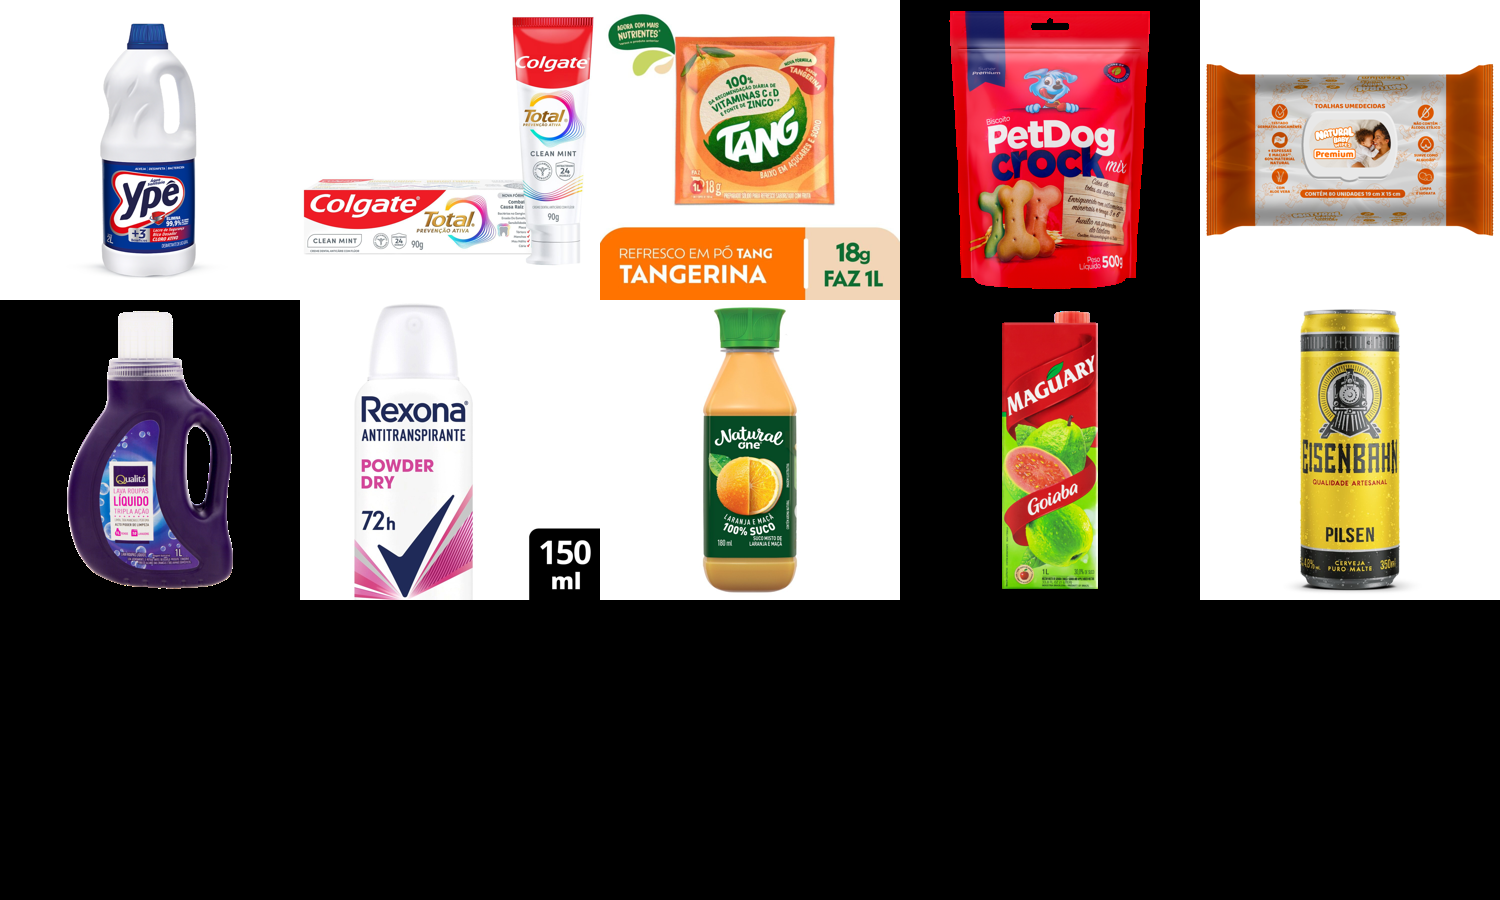

In [125]:
mosaic(best_individual)